In [ ]:

import os
from detanet_model import *

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = []
spec_data = []

# Load the dataset
dataset = torch.load(os.path.join(data_dir, 'KITqm9_dataset.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

print(f"Total dataset length: {len(dataset)}")

ex1 = dataset[0]
ex2 = dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in dataset:
    data.y = torch.cat([data.real, data.imag], dim=0)
    data.spectra = data.spectra.repeat(len(data.z), 1)


ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 5159
Total dataset length: 5159
dataset[0] : Data(pos=[7, 3], idx='KITQM9_34', dataset_name='KITQM9', smiles='OCC#N', polarizability_type='ee', z=[7], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[5] : Data(pos=[9, 3], idx='KITQM9_331', dataset_name='KITQM9', smiles='NC(C#N)C#N', polarizability_type='ee', z=[9], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[0] : Data(pos=[7, 3], idx='KITQM9_34', dataset_name='KITQM9', smiles='OCC#N', polarizability_type='ee', z=[7], freqs=[62], spectra=[7, 62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3])


In [2]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [4]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=3, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=16,
                    rc=3,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params='/media/maria/work_space/dyn-detanet/code/trained_param/pretty-sweep_polar_Falsenormalize_70epochs_32bs_0_0006855550241449846lr_3blocks.pth'
state_dict = torch.load(params)
model.to(device)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_polarizability_elements(data_entry, model, out_dir="."):
    """
    Assumptions:
      - data_entry.real -> shape [N, 3, 3]
      - data_entry.imag -> shape [N, 3, 3]
      - The model returns shape [N, 3, 6], where:
          [:, :, 0:3] => real part (3 columns -> [N, 3, 3])
          [:, :, 3:6] => imag part (3 columns -> [N, 3, 3])
    We then plot the 6 unique elements of a symmetric 3×3 matrix:
      (0,0)=xx, (0,1)=xy, (0,2)=xz, (1,1)=yy, (1,2)=yz, (2,2)=zz
    """


    mol_idx = data_entry.idx
    print(f"Mol idx = {mol_idx}")


    # 2) Convert GT real & imag to NumPy arrays of shape [N, 3, 3]
    real_list = np.array(data_entry.real)  # shape [N, 3, 3]
    imag_list = np.array(data_entry.imag)  # shape [N, 3, 3]
    N = real_list.shape[0]
    print(f"Number of frequency steps = {N}")

    # 3) Get predicted polarizabilities from the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    z = data_entry.z.to(device)
    pos = data_entry.pos.to(device)
    x= data_entry.spectra.to(device)

    with torch.no_grad():
        # pol_spec has shape [N, 3, 6]
        pol_spec = model(z=z, pos=pos, x_features=x).cpu().numpy()
        print("pol_spec", pol_spec.shape)


    # Split out real vs. imaginary from the last dimension
    # first 3 columns => real => shape [N, 3, 3]
    # last 3 columns  => imag => shape [N, 3, 3]

    pred_pol_real = pol_spec[0:62,...]
    pred_pol_imag = pol_spec[62:124,...]
    print("pred_pol_real", pred_pol_real.shape)
    print("pred_pol_imag", pred_pol_imag.shape)

    # 4) We only need the 6 unique elements of the symmetrical 3×3
    pairs = [(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]
    labels = ["xx", "xy", "xz", "yy", "yz", "zz"]


    # ----------------------------------
    # 0)  Collect global min / max once
    # ----------------------------------
    # gather ALL real‐part values (GT + pred)
    real_flat = np.hstack([
        real_list[:, i, j].ravel()          # GT real
        for (i, j) in pairs
    ] + [
        pred_pol_real[:, i, j].ravel()      # pred real
        for (i, j) in pairs
    ])
    rmin, rmax = real_flat.min(), real_flat.max()

    # gather ALL imag‐part values (GT + pred)
    imag_flat = np.hstack([
        imag_list[:, i, j].ravel()          # GT imag
        for (i, j) in pairs
    ] + [
        pred_pol_imag[:, i, j].ravel()      # pred imag
        for (i, j) in pairs
    ])
    imin, imax = imag_flat.min(), imag_flat.max()




    # ---------------- PLOT REAL PART ----------------
    fig_real, axes_real = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
    fig_real.suptitle(f"Polarizability (Real) - Mol idx={mol_idx}", fontsize=14)


    for subplot_idx, (i, j) in enumerate(pairs):
        row = subplot_idx // 2
        col = subplot_idx % 2
        ax = axes_real[row, col]

        # Ground-truth
        gt_vals = real_list[:, i, j]          # shape [N]
        # Predicted
        pred_vals = pred_pol_real[:, i, j]    # shape [N]

        ax.scatter(data_entry.freqs, gt_vals,  label="GT Real",  color="royalblue", alpha=0.5)
        ax.scatter(data_entry.freqs, pred_vals, label="Pred Real", color="tab:orange",  alpha=0.5)

        ax.set_title(f"{labels[subplot_idx]} (Real)")
        ax.set_xlabel("Frequency (eV)")
        ax.set_ylabel("Intensity")
        ax.set_ylim(rmin, rmax)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, f"polar_elements_real_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show()
    plt.close(fig_real)

    # ---------------- PLOT IMAG PART ----------------
    fig_imag, axes_imag = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
    fig_imag.suptitle(f"Polarizability (Imag) - Mol idx={mol_idx}", fontsize=14)


    for subplot_idx, (i, j) in enumerate(pairs):
        row = subplot_idx // 2
        col = subplot_idx % 2
        ax = axes_imag[row, col]

        # Ground-truth
        gt_vals = imag_list[:, i, j]          # shape [N]

        # Predicted
        pred_vals = pred_pol_imag[:, i, j]    # shape [N]

        ax.scatter(data_entry.freqs, gt_vals,  label="GT Imag",  color="royalblue", alpha= 0.5)
        ax.scatter(data_entry.freqs, pred_vals, label="Pred Imag", color="tab:orange",  alpha=0.5)

        ax.set_title(f"α_{labels[subplot_idx]} (Imag)")
        ax.set_xlabel("Frequency (eV)")
        ax.set_ylabel("Intensity")
        ax.set_ylim(imin, imax)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"polar_elements_imag_{mol_idx}_{data_entry.dataset_name}.png"), dpi=300)
    plt.show()
    plt.close(fig_imag)


Mol idx = KITQM9_70289
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


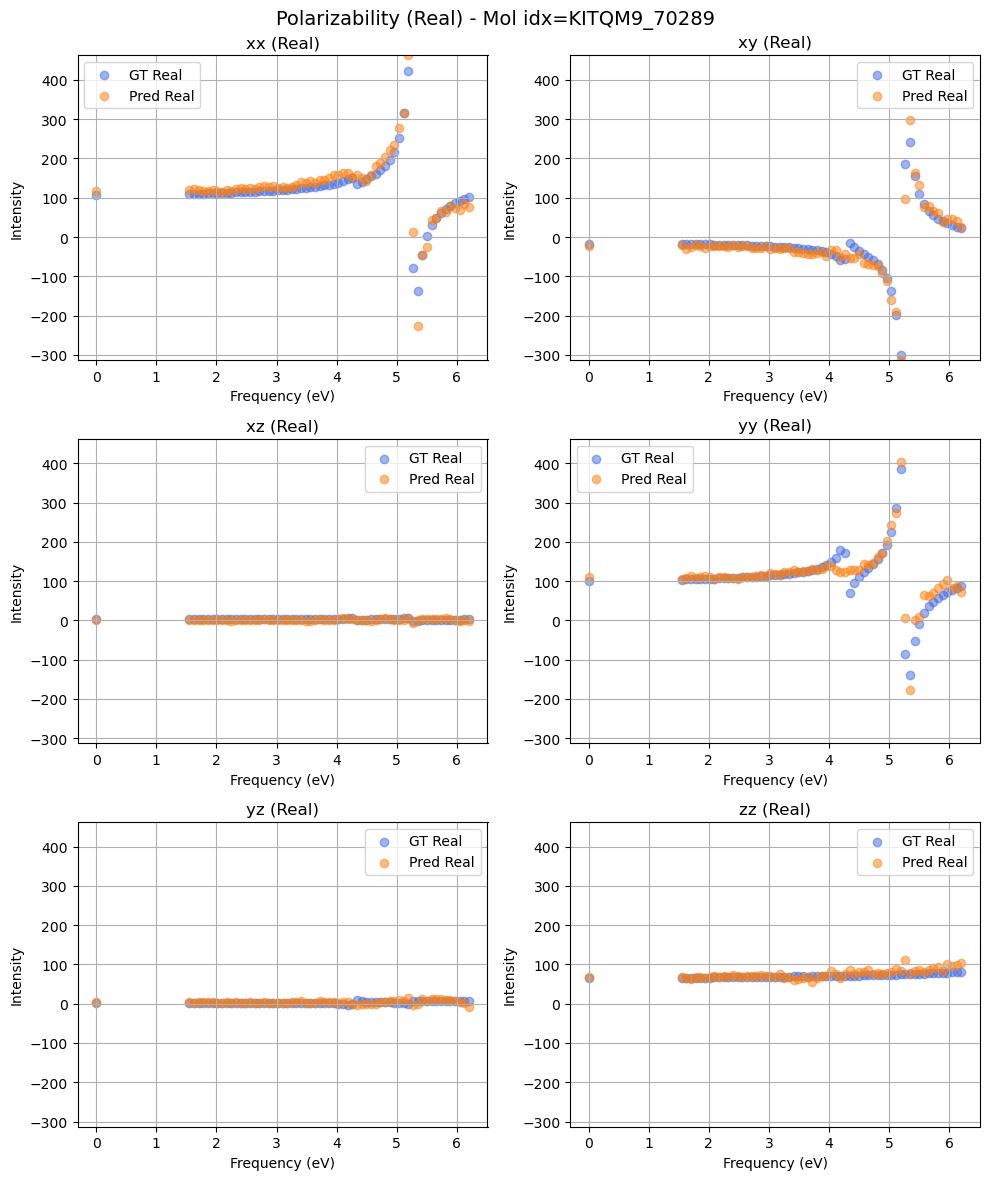

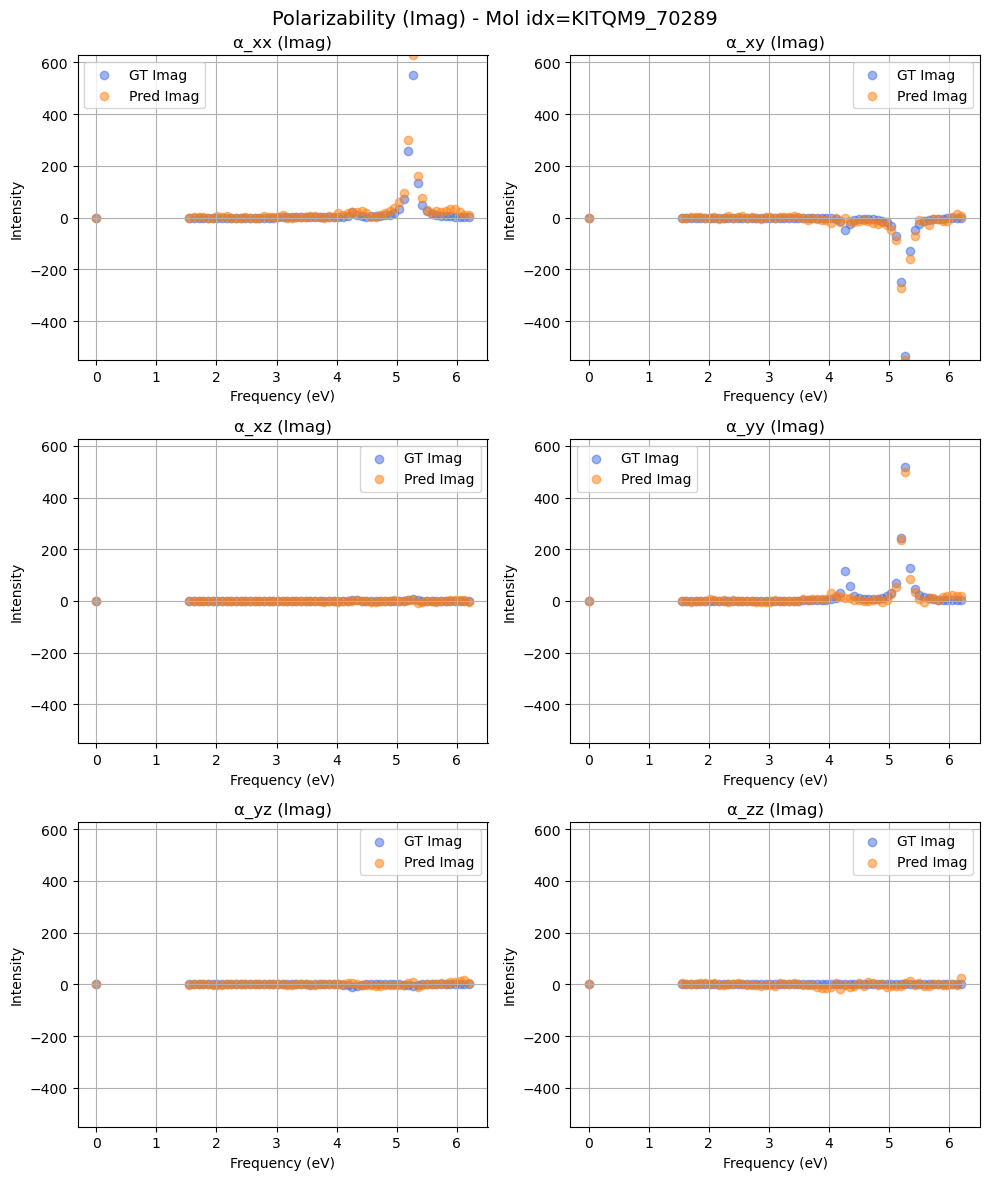

Mol idx = KITQM9_123503
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


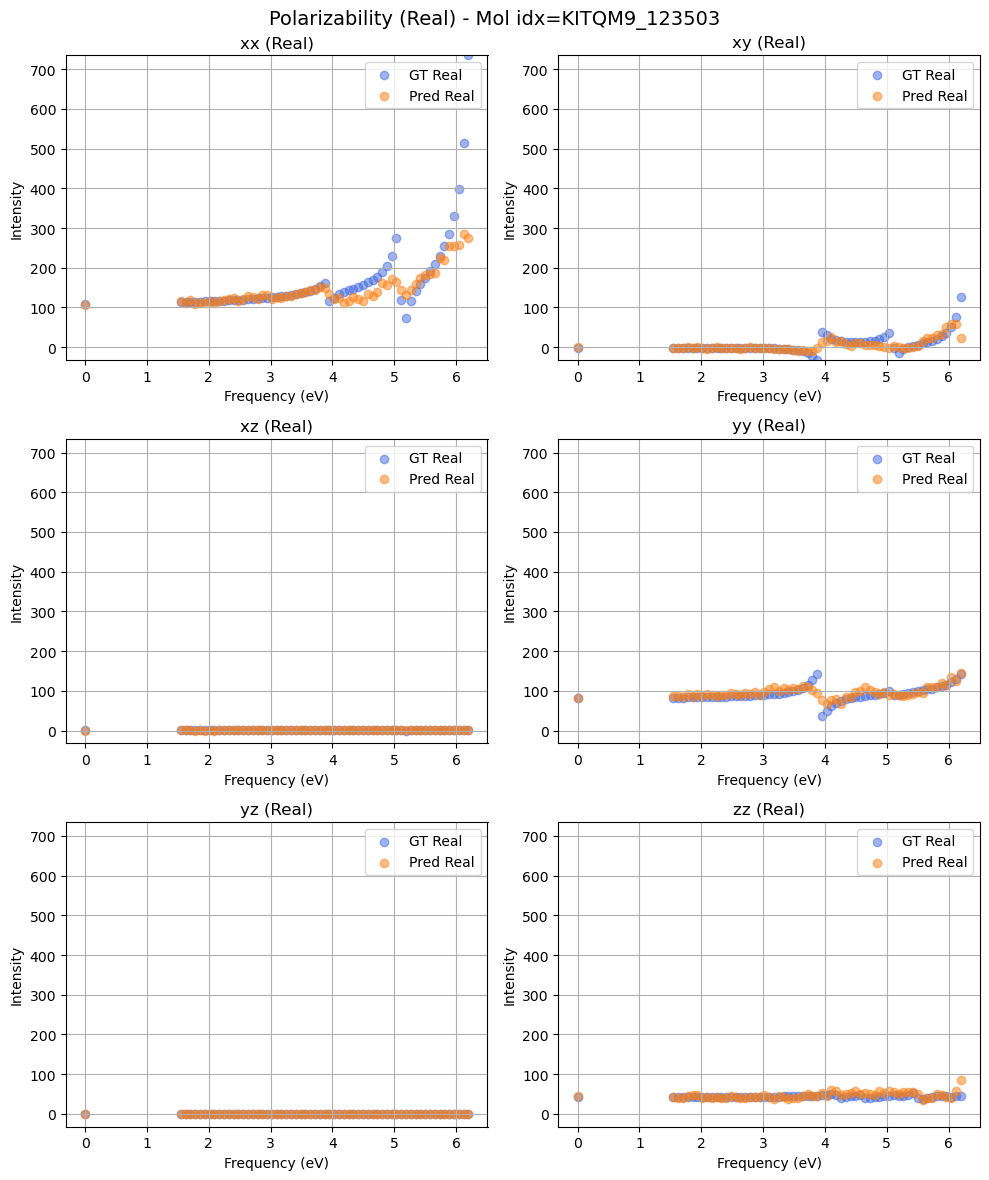

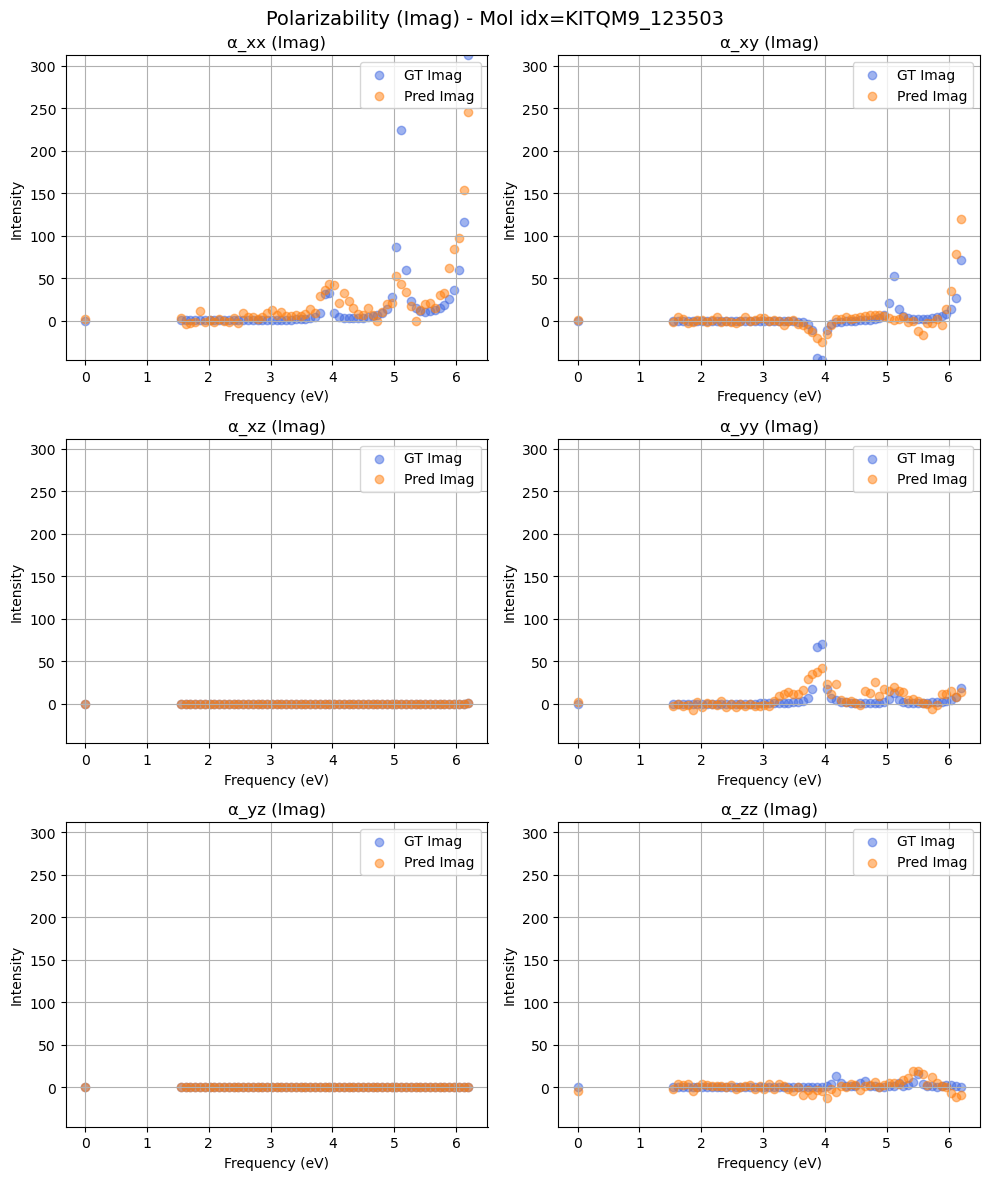

Mol idx = KITQM9_95777
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


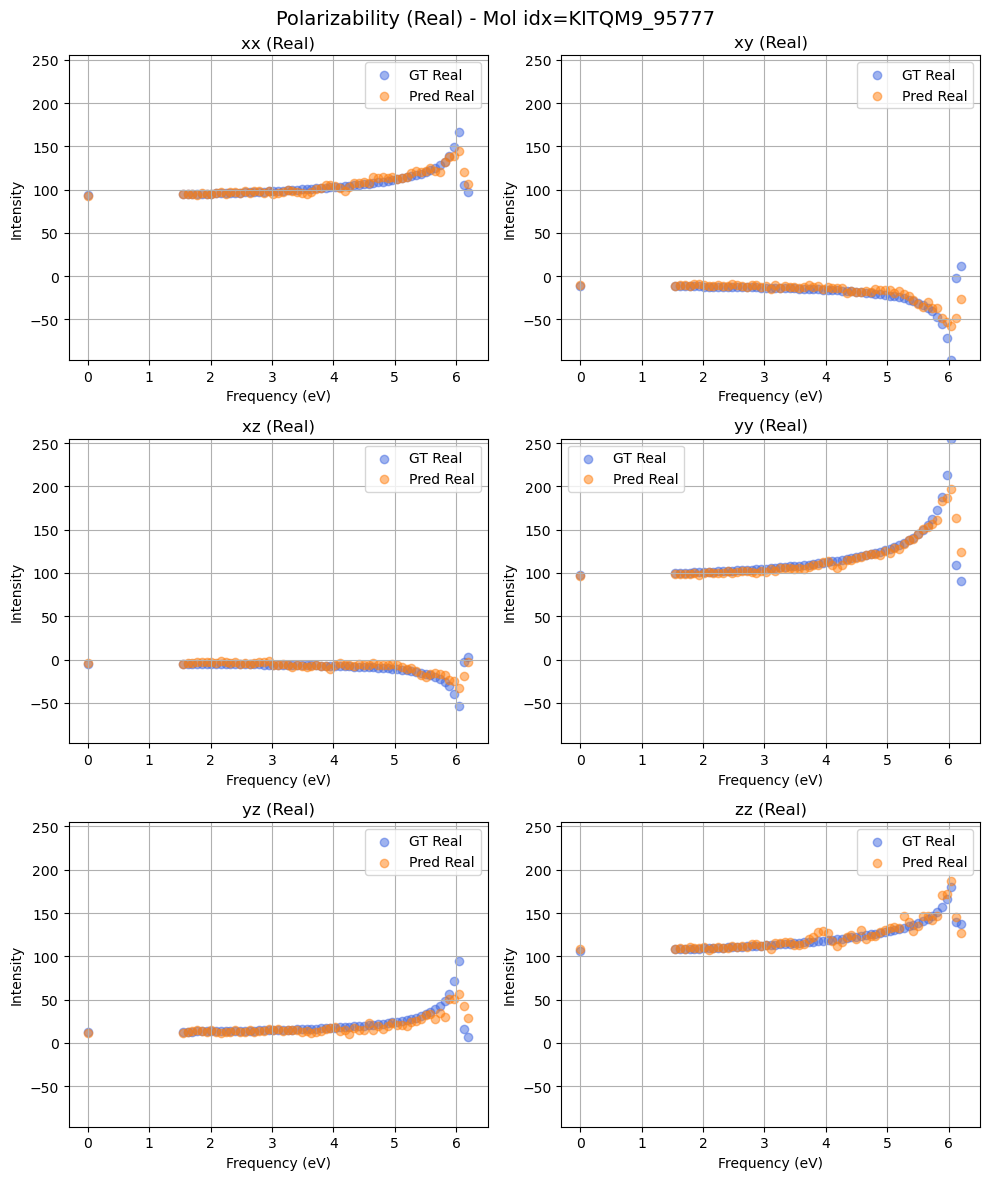

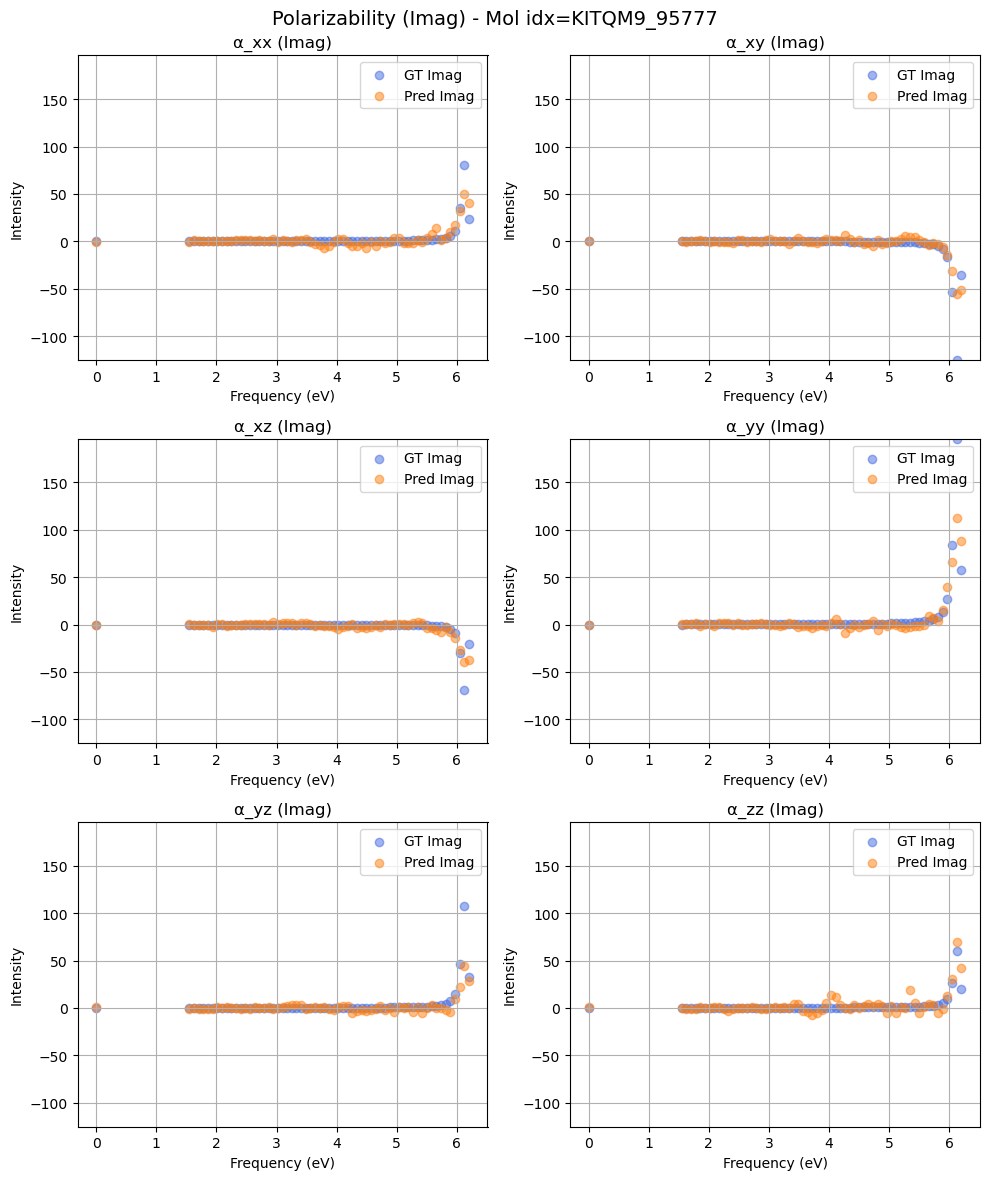

Mol idx = KITQM9_118559
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


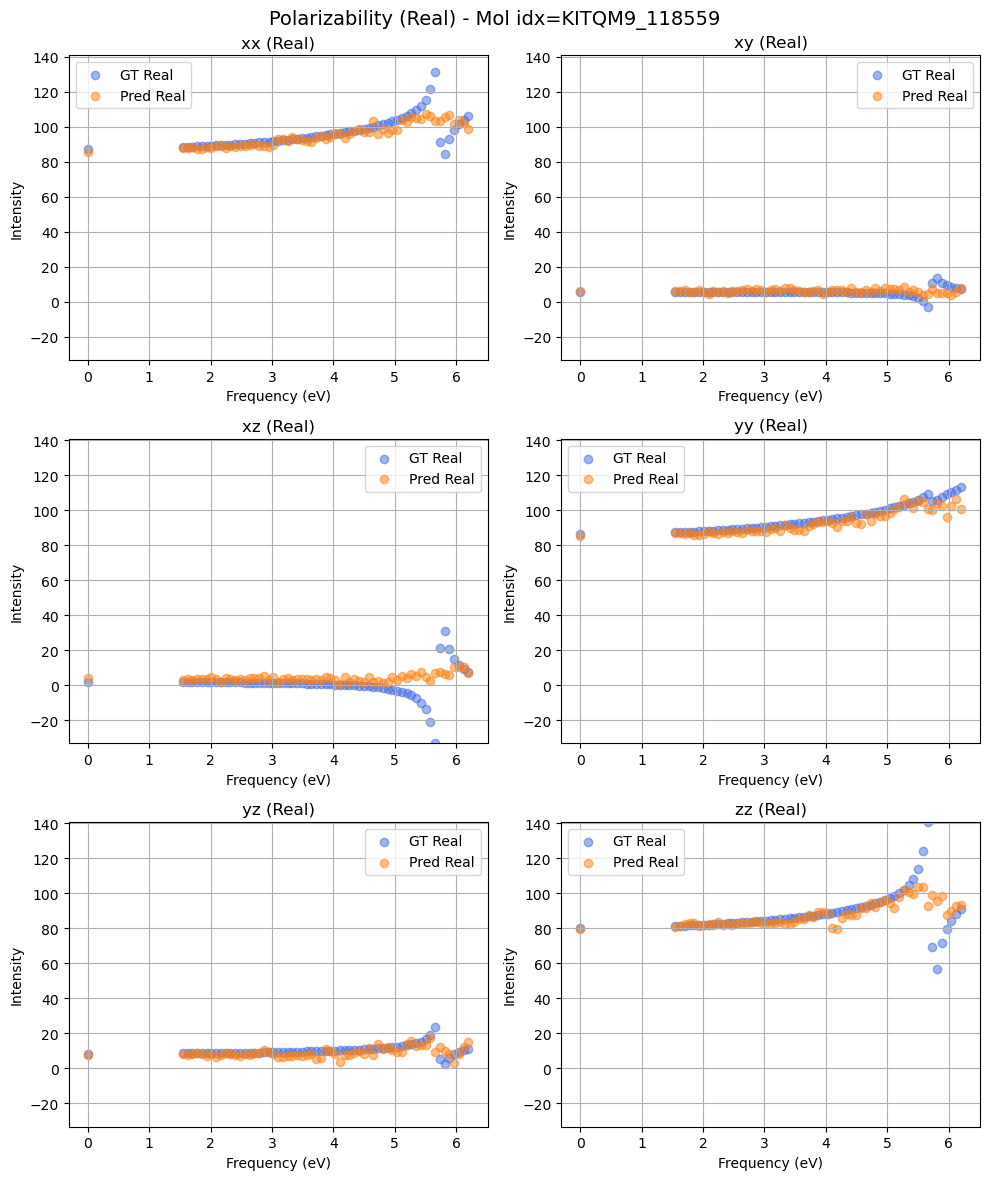

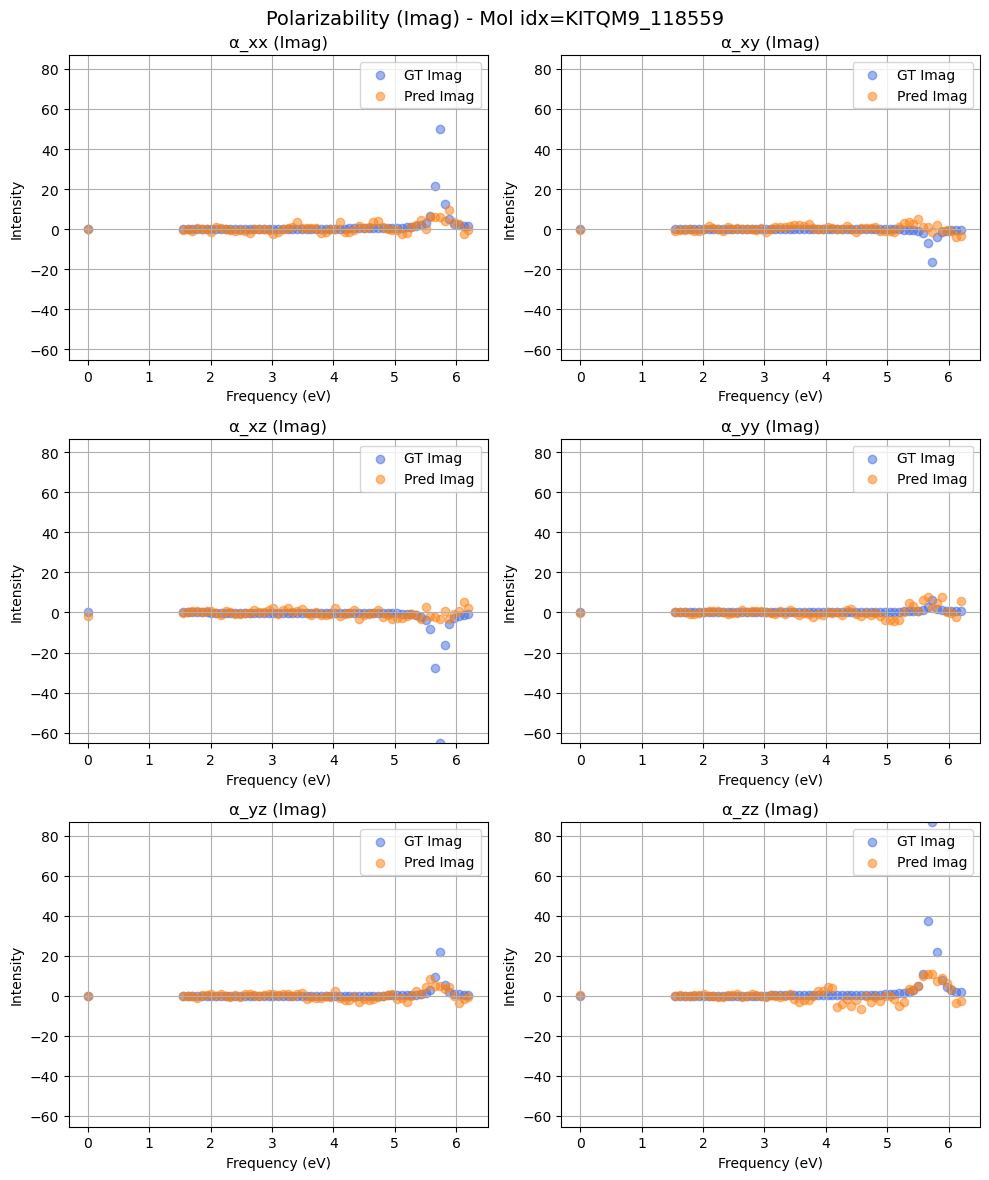

In [10]:
for i in range(4):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry ,model, out_dir="/media/maria/work_space/detanet-complex/images/OPT_pred_molcules")

# HOPV Dataset

In [17]:

import os
from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader

import trainer
from detanet_model import *

import wandb
import random
random.seed(42)

batch_size = 64
epochs = 100
lr=5e-4
cutoff=5.0
num_block=3
num_features=128

finetune = False
# -------------------------------

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

HOPV_dataset = []
spec_data = []

# Load the dataset
HOPV_dataset = torch.load(os.path.join(data_dir, 'HOPV_dataset.pt'))
print(f"Number of graphs in the dataset: {len(HOPV_dataset)}")

print(f"Total dataset length: {len(HOPV_dataset)}")

ex1 = HOPV_dataset[0]
ex2 = HOPV_dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

for data in HOPV_dataset:
    data.y = torch.cat([data.real, data.imag], dim=0)


ex1 = HOPV_dataset[0]
print("dataset[0] :", ex1, )





Number of graphs in the dataset: 347
Total dataset length: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', polarizability_type='ee', z=[68], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[5] : Data(pos=[55, 3], idx='HOPV_5', dataset_name='HOPV', smiles='C#Cc1cc(OC)c(C#Cc2scc3nc(-c4ccccc4)c(-c4ccccc4)nc32)cc1OC', polarizability_type='ee', z=[55], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15])
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', polarizability_type='ee', z=[68], freqs=[62], spectra=[62], real=[62, 3, 3], imag=[62, 3, 3], polar=[62, 6, 3], osc_pos=[15], osc_strength=[15], y=[124, 3, 3])


In [18]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(HOPV_dataset)
train_frac = 0.9
split_index = int(train_frac * len(HOPV_dataset))

HOPV_train_datasets = HOPV_dataset[:split_index]
HOPV_val_datasets   = HOPV_dataset[split_index:]


In [19]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_HOPV = DetaNet(num_features=128,
                    act='swish',
                    maxl=3,
                    num_block=6, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=8,
                    rc=6.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    device=device)


params='/media/maria/work_space/detanet-complex/code/trained_param/Finetune_polar_85epochs_16batchsize_0_0009lr_6_0cutoff_6numblock_NICE_ONE.pth'
state_dict = torch.load(params)
model_HOPV.to(device)
model_HOPV.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

Mol idx = HOPV_110
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


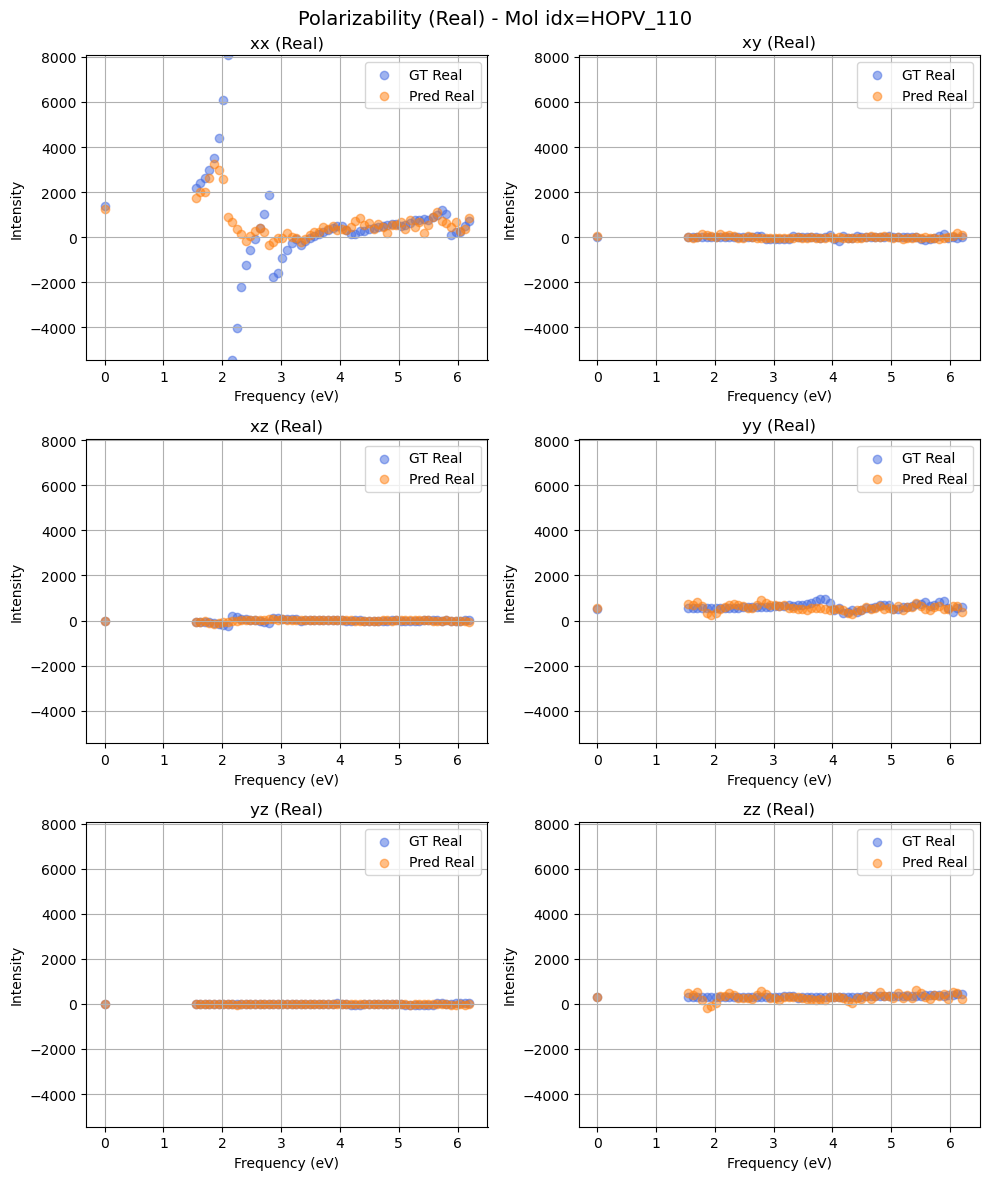

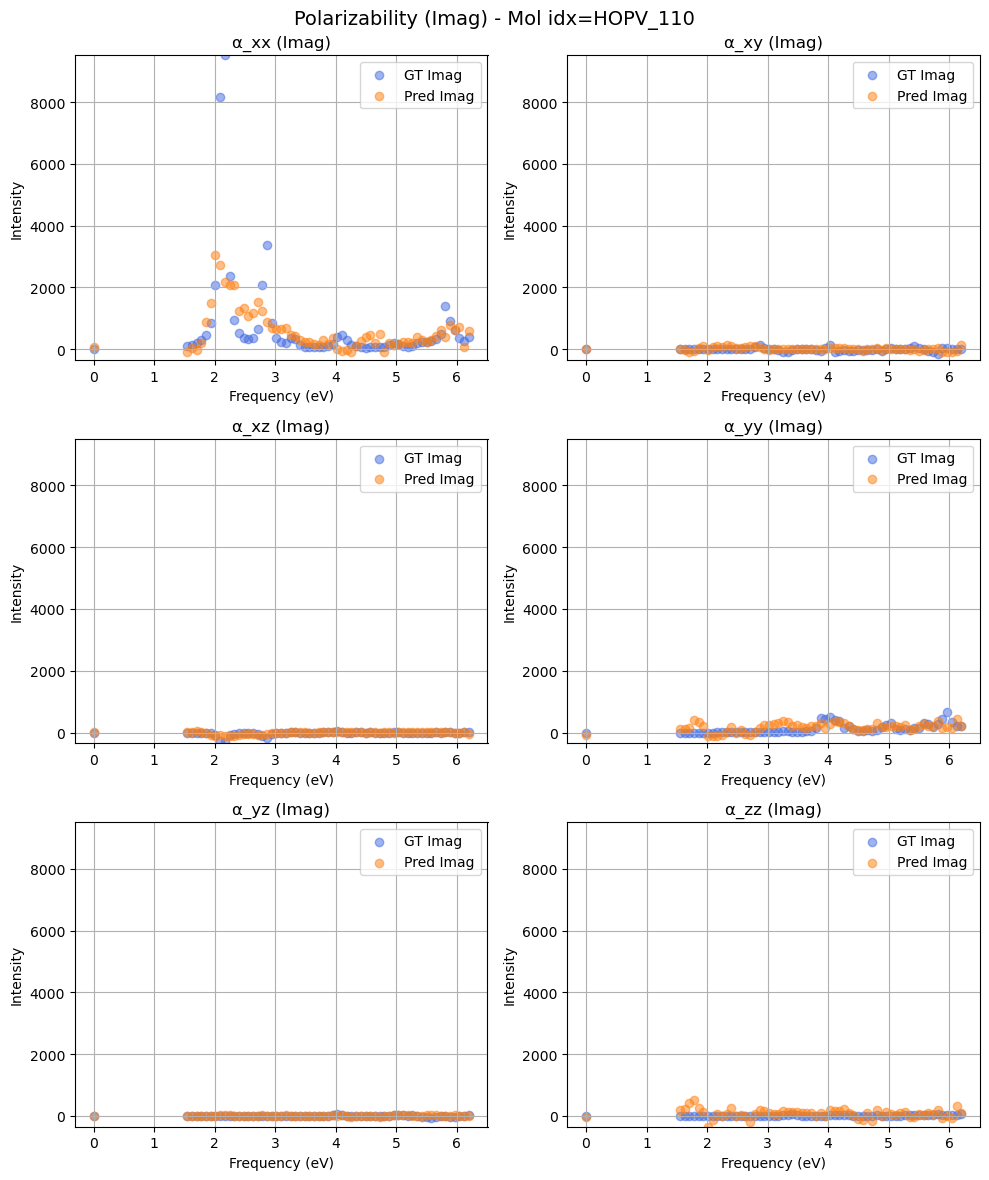

Mol idx = HOPV_79
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


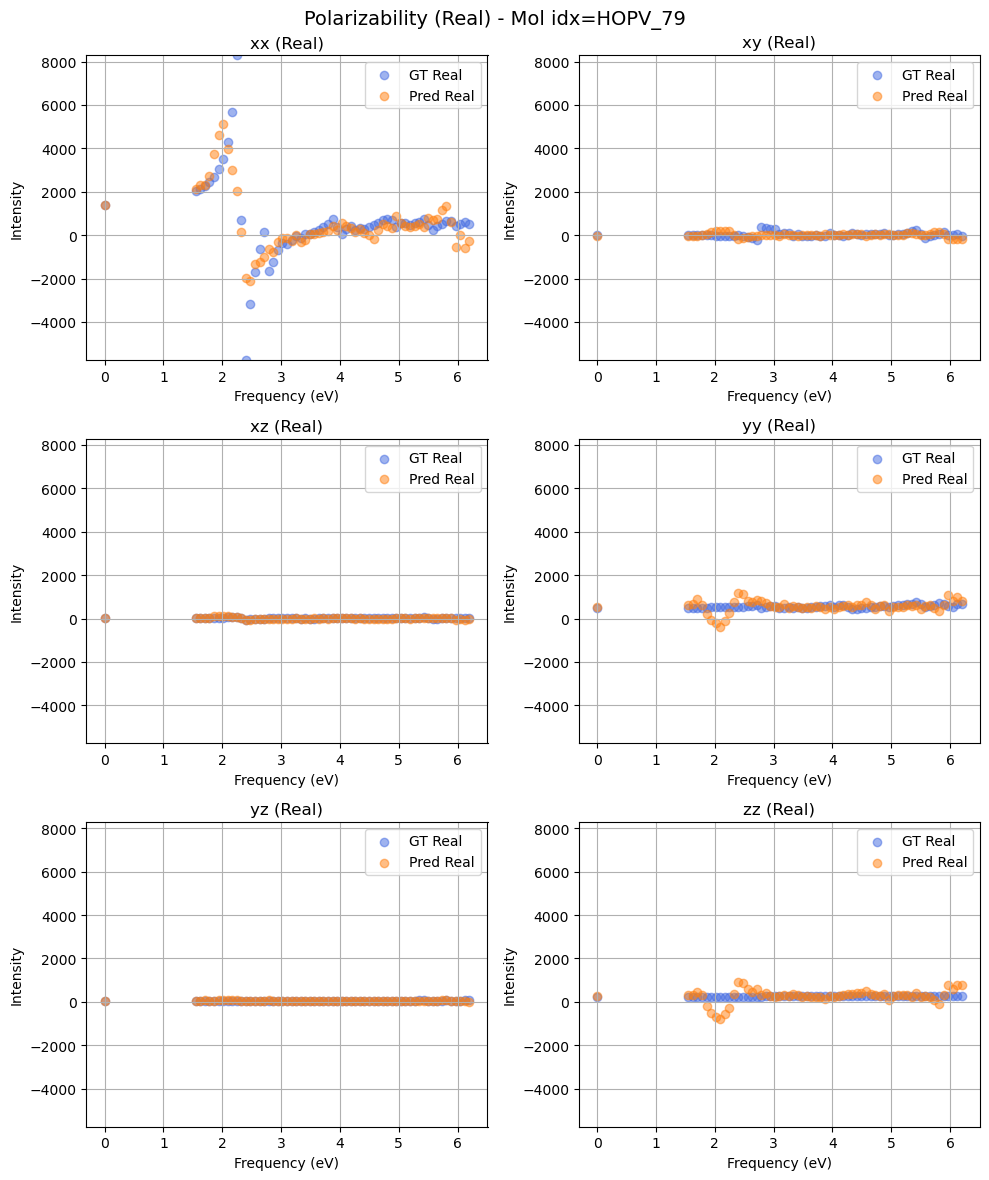

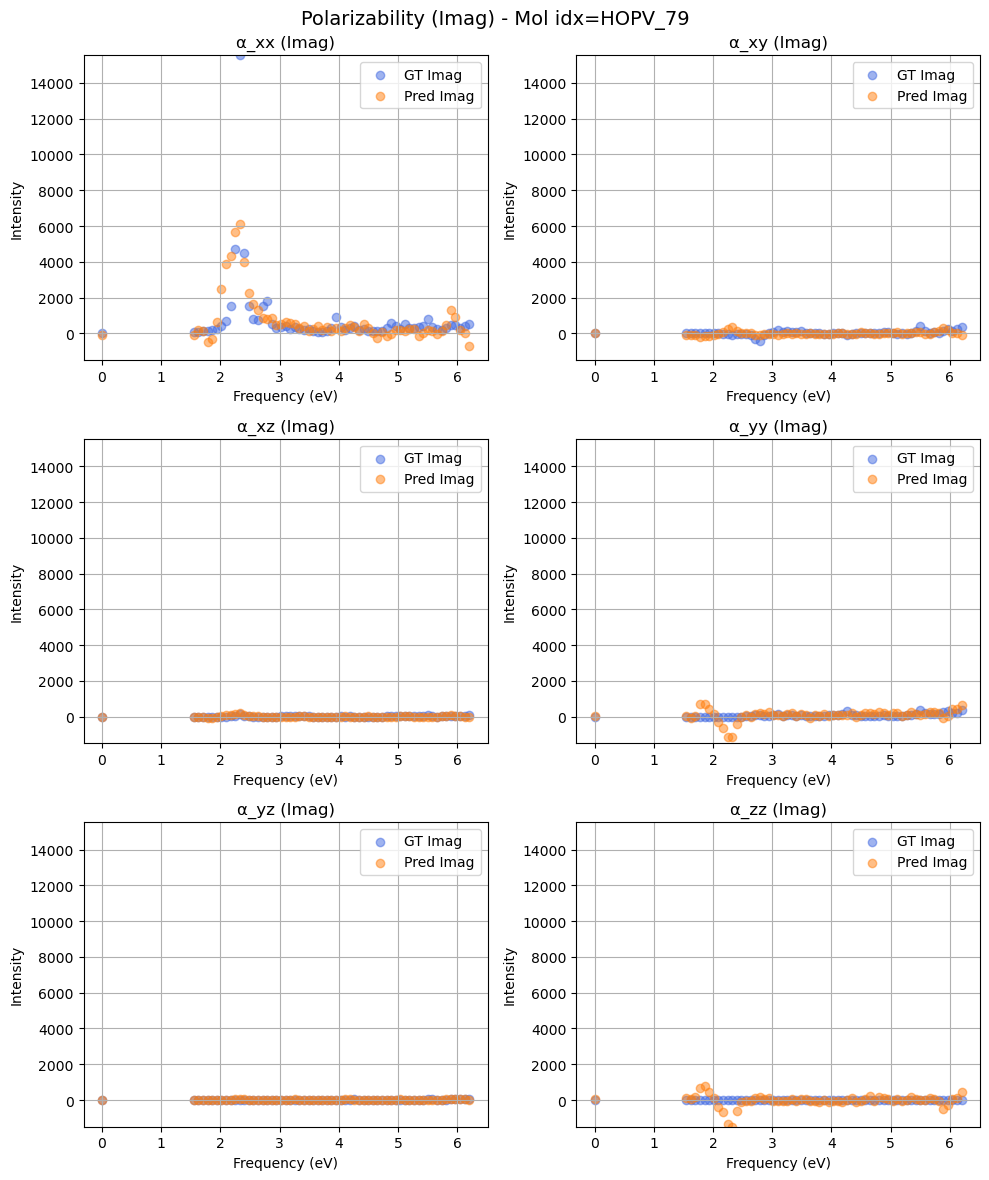

Mol idx = HOPV_319
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


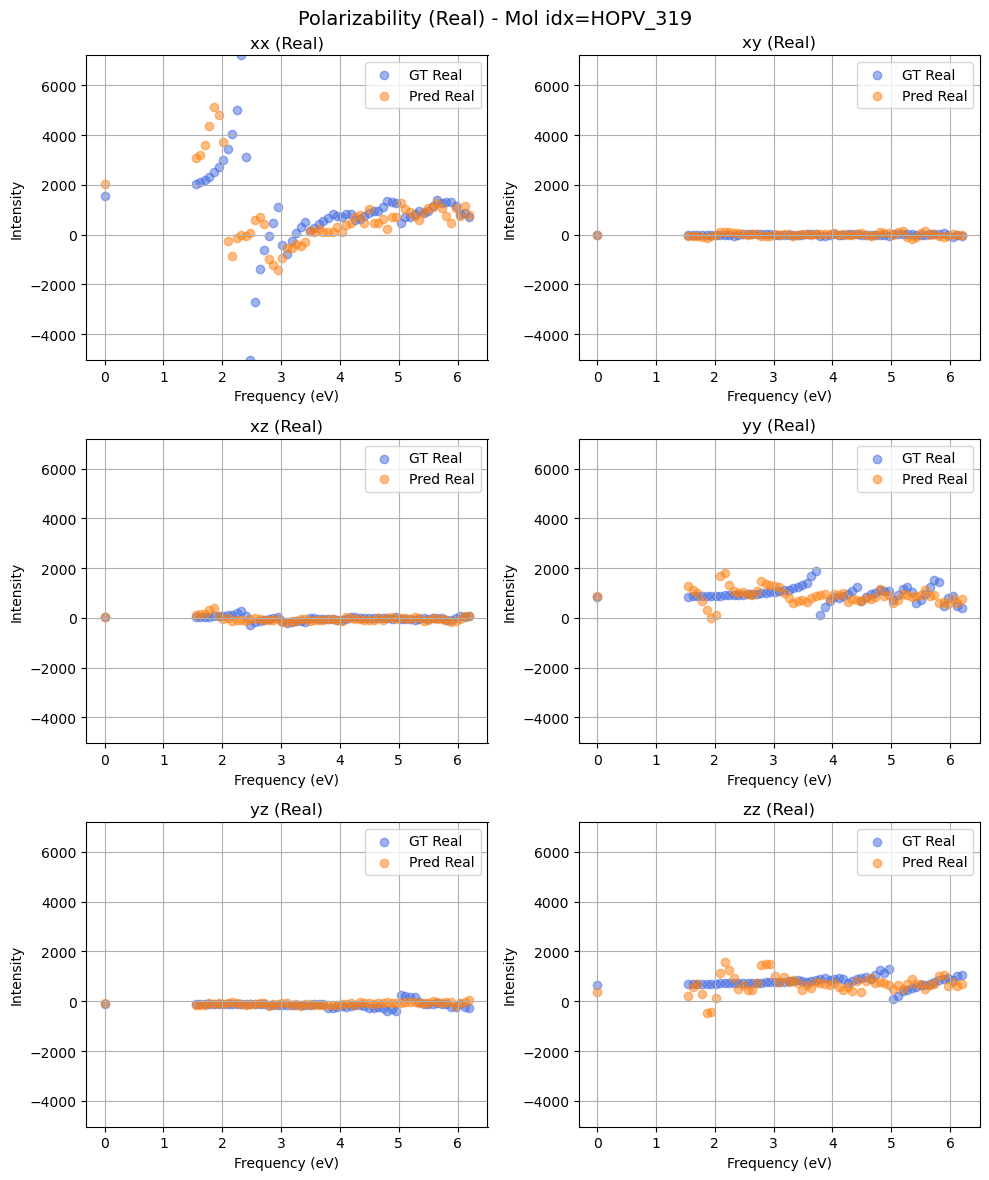

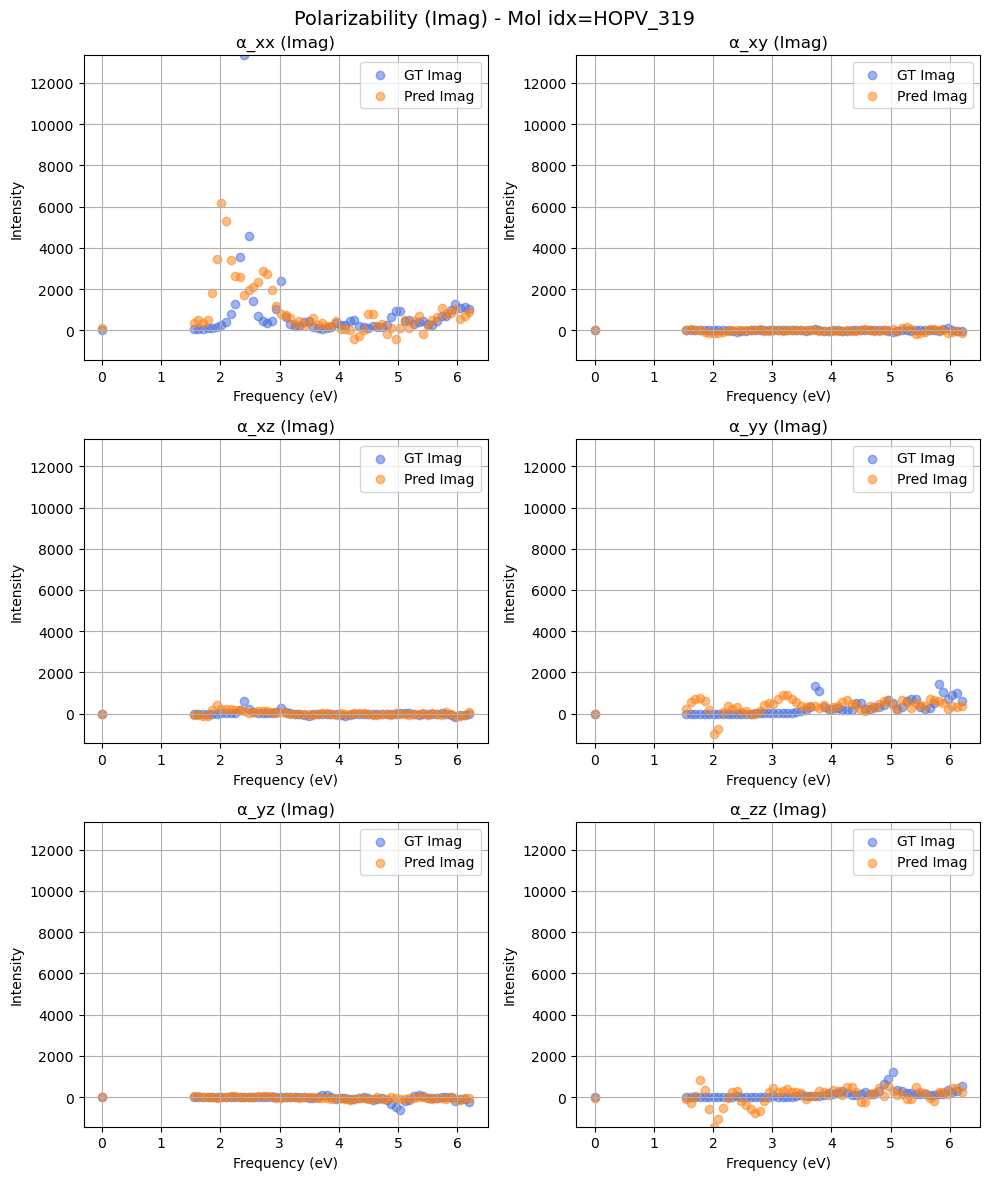

Mol idx = HOPV_174
Number of frequency steps = 62
pol_spec (124, 3, 3)
pred_pol_real (62, 3, 3)
pred_pol_imag (62, 3, 3)


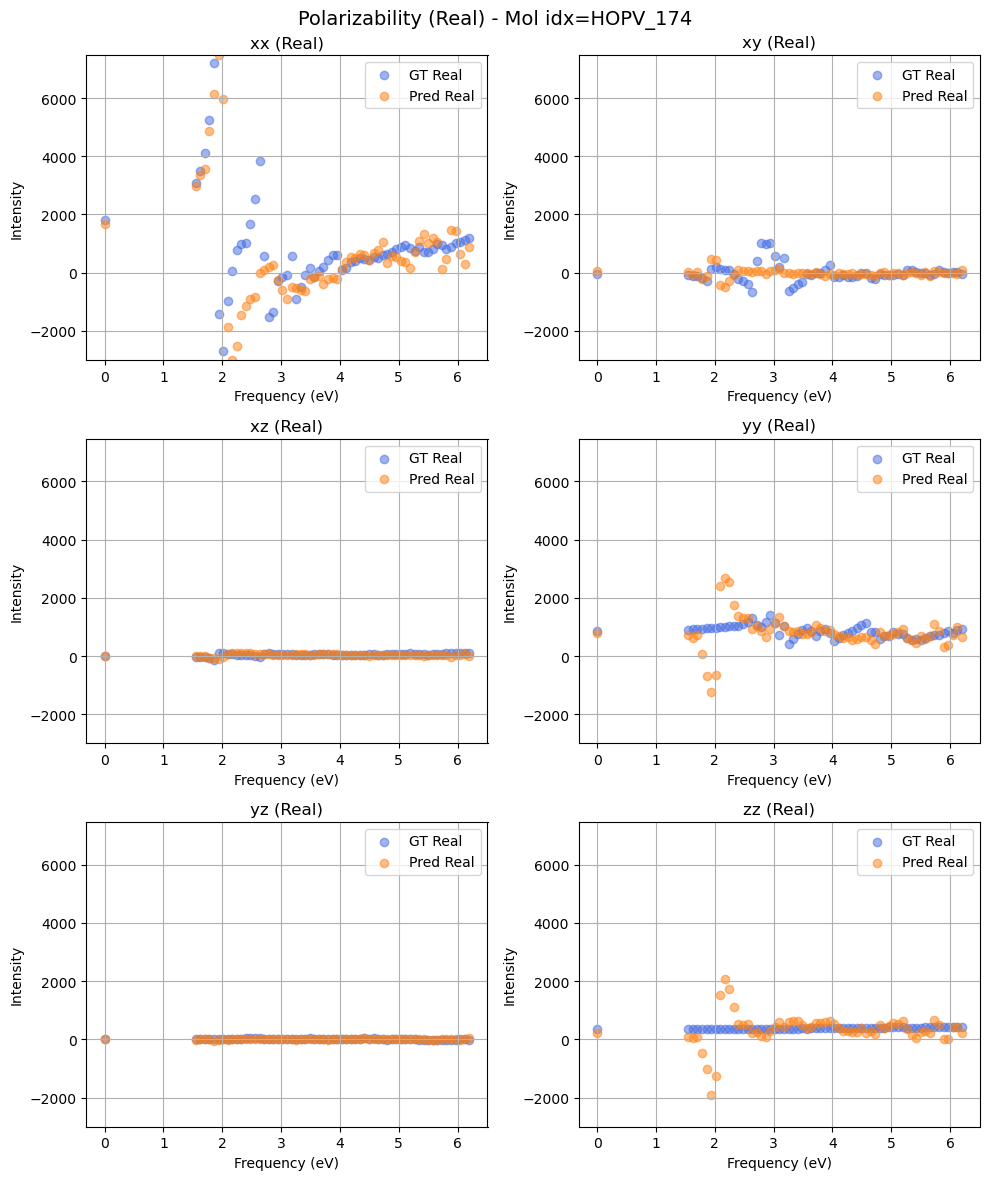

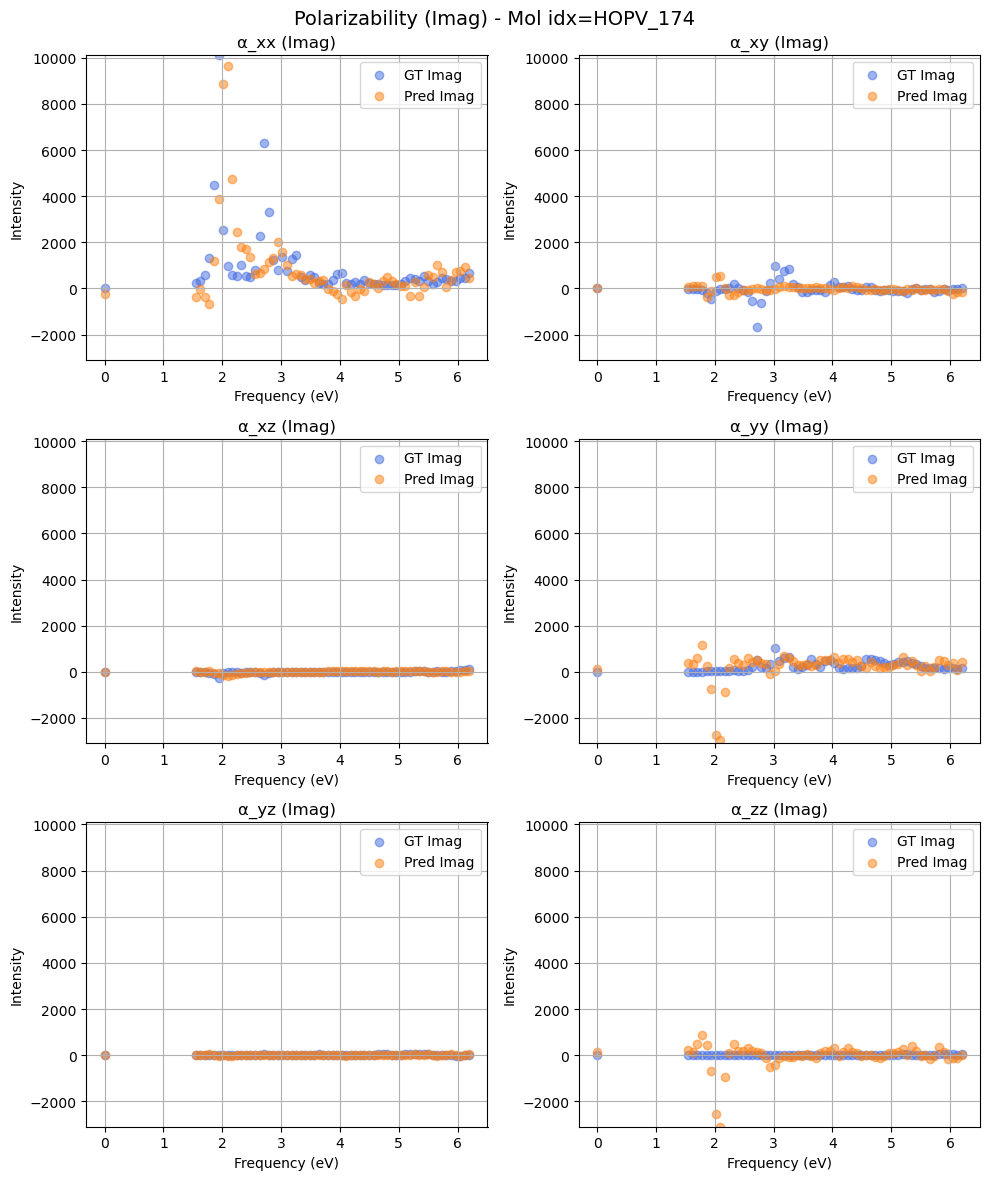

In [20]:
for i in range(4):
    data_entry = HOPV_val_datasets[i]  # Assuming you want to plot the first entry
    plot_polarizability_elements(data_entry ,model_HOPV, out_dir="/media/maria/work_space/detanet-complex/images/OPT_pred_molcules")